### 导入需要用到的包

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pylab as plt
import numpy as np
import seaborn as sb
import mplfinance as mpl 

### 读取数据

In [2]:
df = pd.read_parquet("2022interview.parquet")

### 检查字段总结

In [3]:
df[df["Volume"]!=0][1000:1005]

,LocalTime,TradingDay,InstrumentID,ExchangeID,LastPrice,Volume,Turnover,UpperLimitPrice,LowerLimitPrice,UpdateTime,UpdateMillisec,ActionDay
1930,1640091611935386170,20211222,sc2202,INE,455.8,483,220206100.0,482.6,411.1,21:00:11,500,20211221
1931,1640091611935760646,20211222,sc2203,INE,453.9,47,21345400.0,482.0,410.5,21:00:11,500,20211221
1932,1640091611936596304,20211222,sc2204,INE,452.2,2,904900.0,479.5,408.4,21:00:11,500,20211221
1933,1640091611947450615,20211222,sc2206,INE,451.7,1,451700.0,479.8,408.7,21:00:11,500,20211221
1941,1640091611947468870,20211222,ag2201,SHFE,4797.0,102,7341960.0,5185.0,4242.0,21:00:11,500,20211221


In [4]:
df.describe()

,LocalTime,LastPrice,Volume,Turnover,UpperLimitPrice,LowerLimitPrice,UpdateMillisec
count,7.046690e+05,704669.000000,704669.000000,7.046690e+05,704669.000000,704669.000000,704669.000000
mean,1.640098e+18,3860.181600,43989.556304,4.069115e+09,4127.132380,3529.156366,259.276568
std,4.943184e+12,2921.971717,97699.386055,9.055260e+09,3120.799181,2701.389967,291.830362
min,1.640090e+18,366.900000,0.000000,0.000000e+00,390.480000,346.260000,0.000000
25%,1.640094e+18,458.600000,780.000000,3.443180e+07,482.000000,410.500000,0.000000
50%,1.640097e+18,4680.000000,6338.000000,3.305904e+08,4836.000000,4248.000000,26.000000
75%,1.640100e+18,4839.000000,23889.000000,2.343856e+09,5250.000000,4328.000000,500.000000
max,1.640111e+18,8976.000000,545584.000000,5.552315e+10,9410.000000,8182.000000,999.000000


In [5]:
df.describe(include = ["O"])

,TradingDay,InstrumentID,ExchangeID,UpdateTime,ActionDay
count,704669,704669,704669,704669,704669
unique,2,96,4,19947,2
top,20211222,sc2202,SHFE,21:00:04,20211221
freq,564932,35922,255898,152,433539


### 检查LocalTime字段的单调性

In [6]:
df["LocalTime"].is_monotonic

True

In [7]:
df["LocalTime"].is_monotonic and df["LocalTime"].is_unique

True

以上结果显示LocalTime字段具有严格单调性（单调递增）。

### 分交易所统计(UpdateTime,UpdateMullisec)单调性

In [8]:
max(df["UpdateMillisec"])

999

检查毫秒最大值，确定不会跨秒。

In [9]:
df["UpdateTime_full"] = df["UpdateTime"] + pd.to_timedelta(df["UpdateMillisec"], "milliseconds")

/opt/anaconda3/envs/DATA1030_env/lib/python3.9/site-packages/pandas/core/arrays/datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


合并UpdateTime和UpdateMillisec

In [10]:
df[df["UpdateTime_full"] < "0 days 05:00:00.000000"].groupby(["ExchangeID"])["UpdateTime_full"]\
.apply(lambda x: x.is_monotonic)

ExchangeID
INE     True
SHFE    True
Name: UpdateTime_full, dtype: bool

In [11]:
df[df["UpdateTime_full"] > "0 days 05:00:00.000000"].groupby(["ExchangeID"])["UpdateTime_full"]\
.apply(lambda x: x.is_monotonic)

ExchangeID
CZCE    False
DCE     False
INE      True
SHFE     True
Name: UpdateTime_full, dtype: bool

以凌晨五点为分界线，将跨天的交易时间分开。根据交易所分组，查看每组UpdateTime和UpdateMillisec合并后的单调性。

交易所INE和SHFE的UpdateTime和UpdateMullisec字段具有单调性，但交易所DCE和交易所CZCE不具有单调性。

In [12]:
df[df["UpdateTime_full"] < "0 days 05:00:00.000000"].groupby(["ExchangeID","InstrumentID"])["UpdateTime_full"]\
.apply(lambda x: x.is_monotonic).unique()

array([ True])

In [13]:
df[df["UpdateTime_full"] > "0 days 05:00:00.000000"].groupby(["ExchangeID","InstrumentID"])["UpdateTime_full"]\
.apply(lambda x: x.is_monotonic).unique()

array([ True])

根据ExchangeID和InstrumentID进行分组则可以看出，每个合约的UpdateTime和UpdateMullisec字段都具有单调性。

### 探索每个交易所的tick的推送频率

max: 1738985034346.0, min: 1161.0
Proportion of records with time_diff > 1000000000: 0.00002


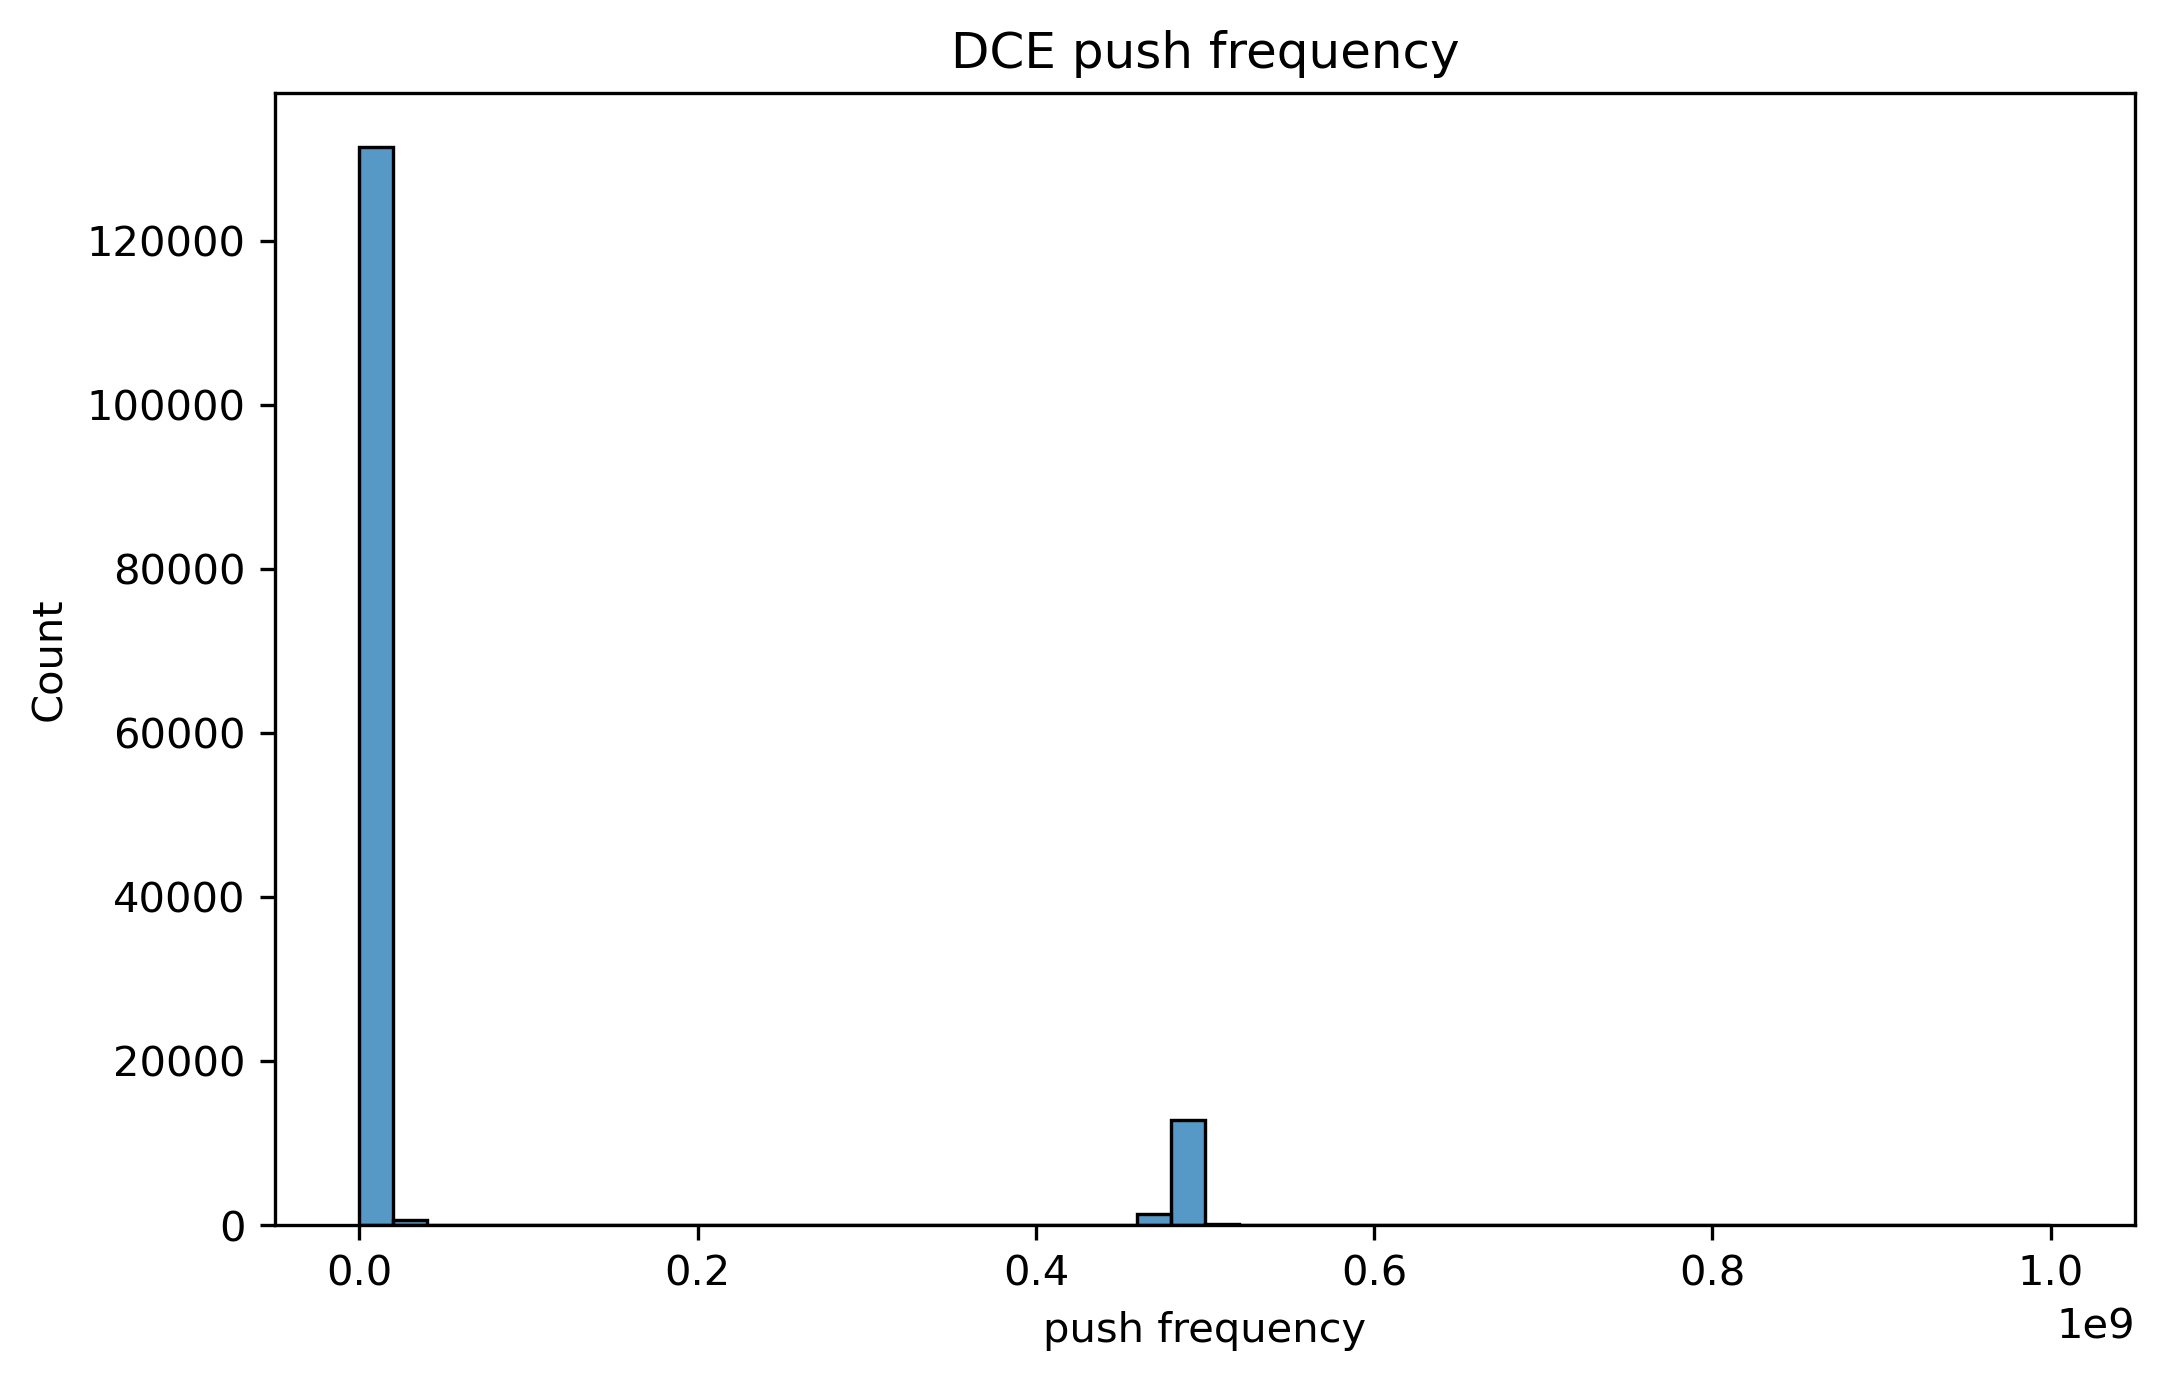

max: 1738403799620.0, min: 1144.0
Proportion of records with time_diff > 1000000000: 0.00138


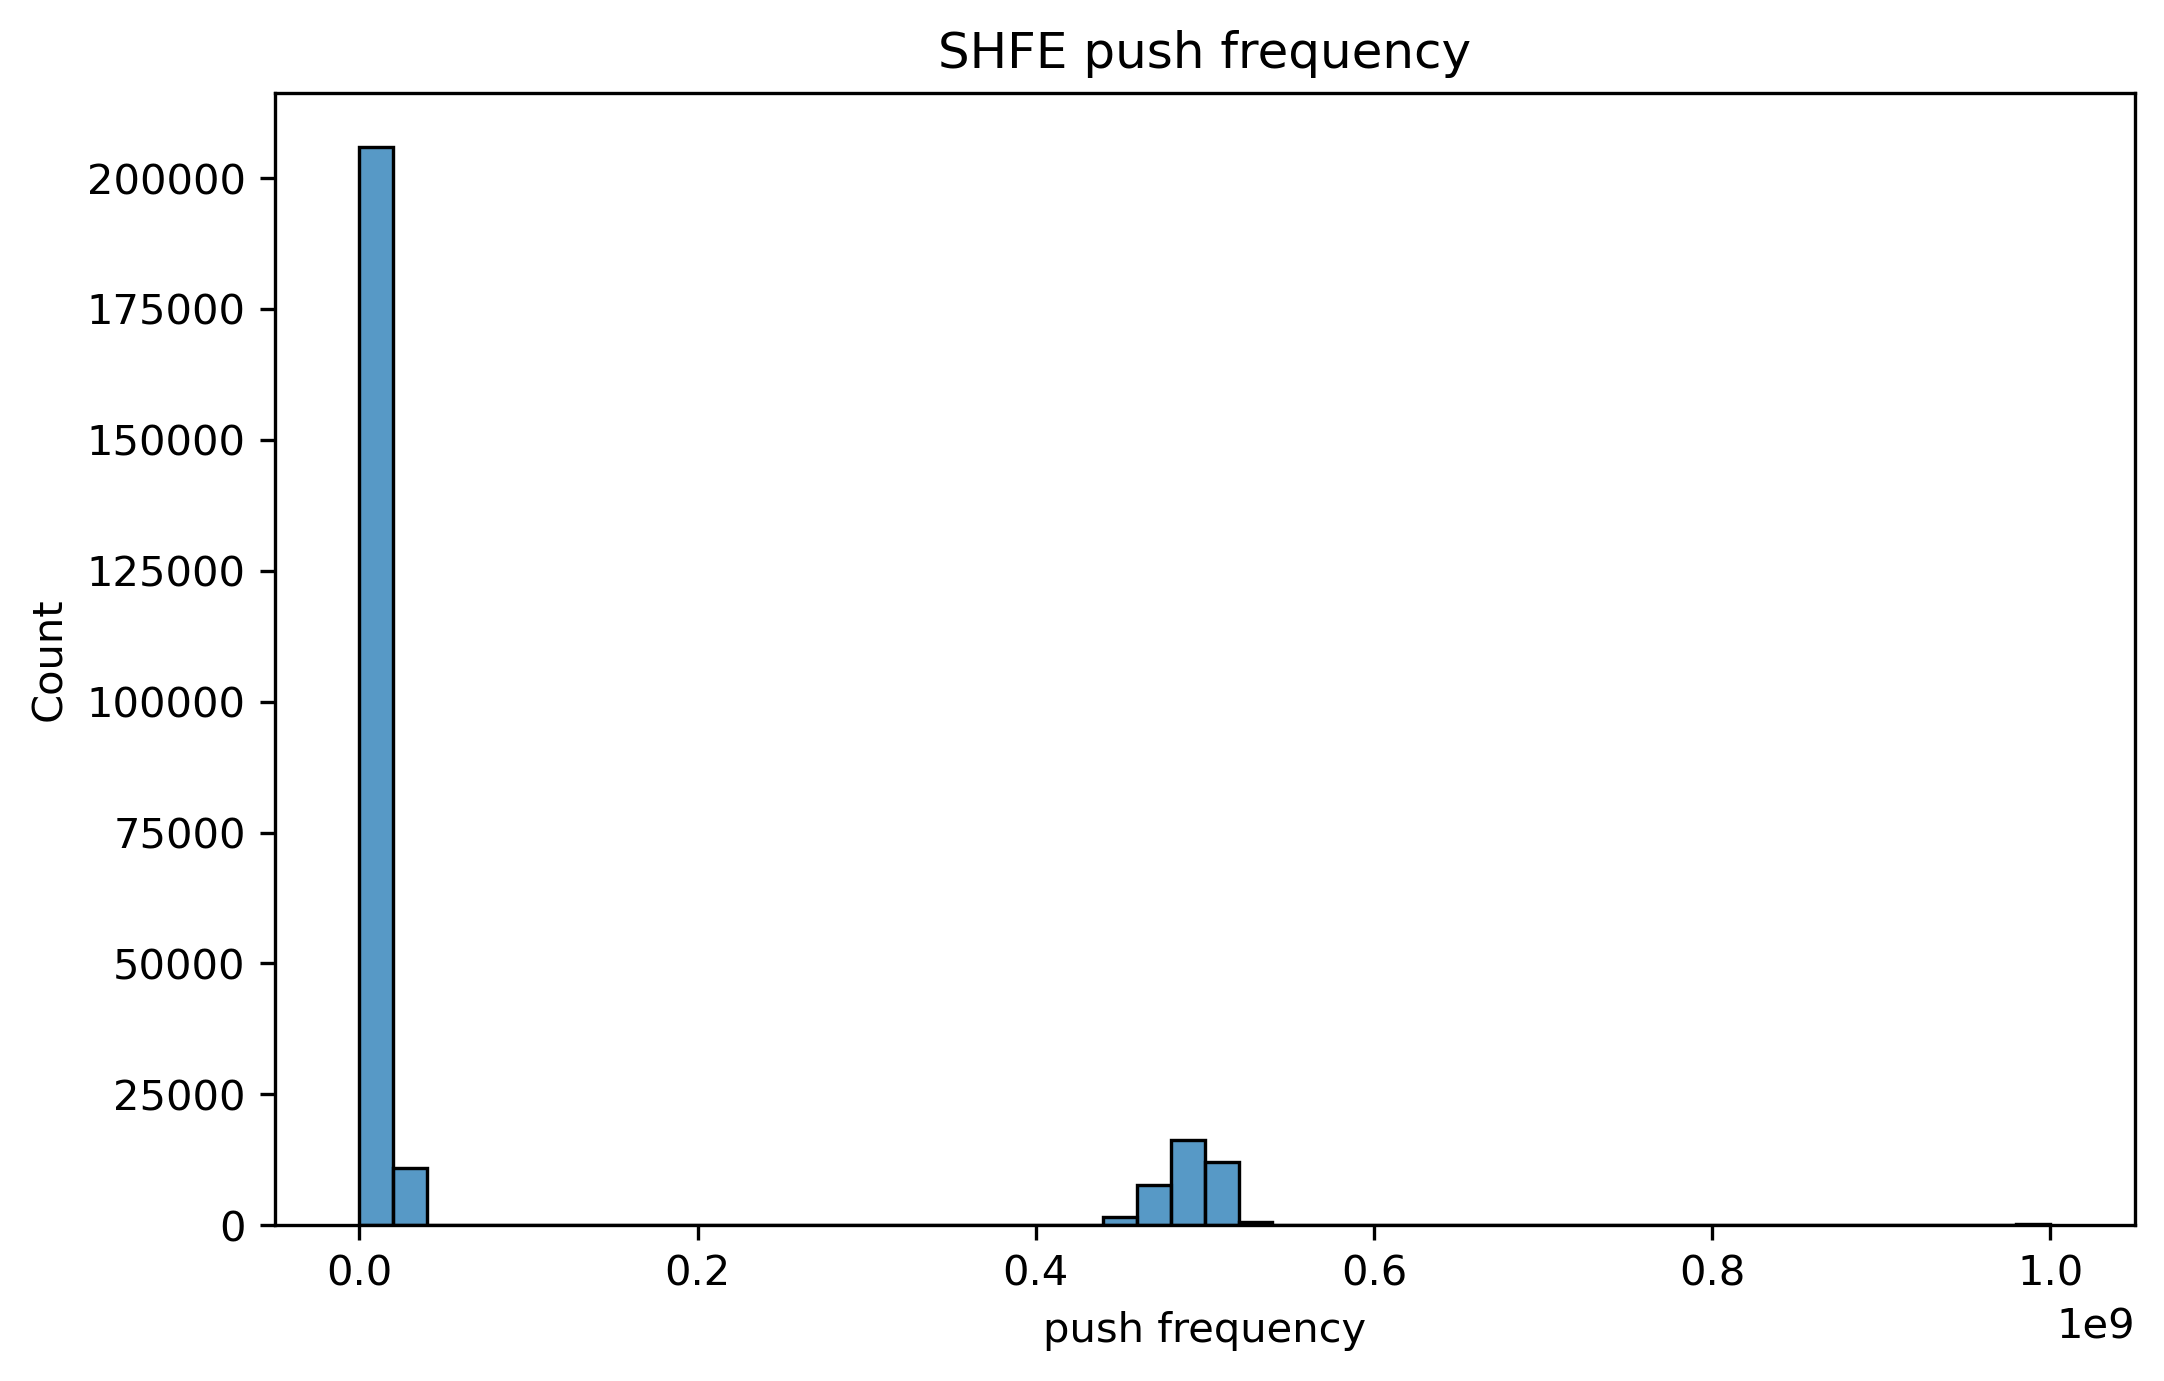

max: 1497587297706.0, min: 1365.0
Proportion of records with time_diff > 1000000000: 0.00057


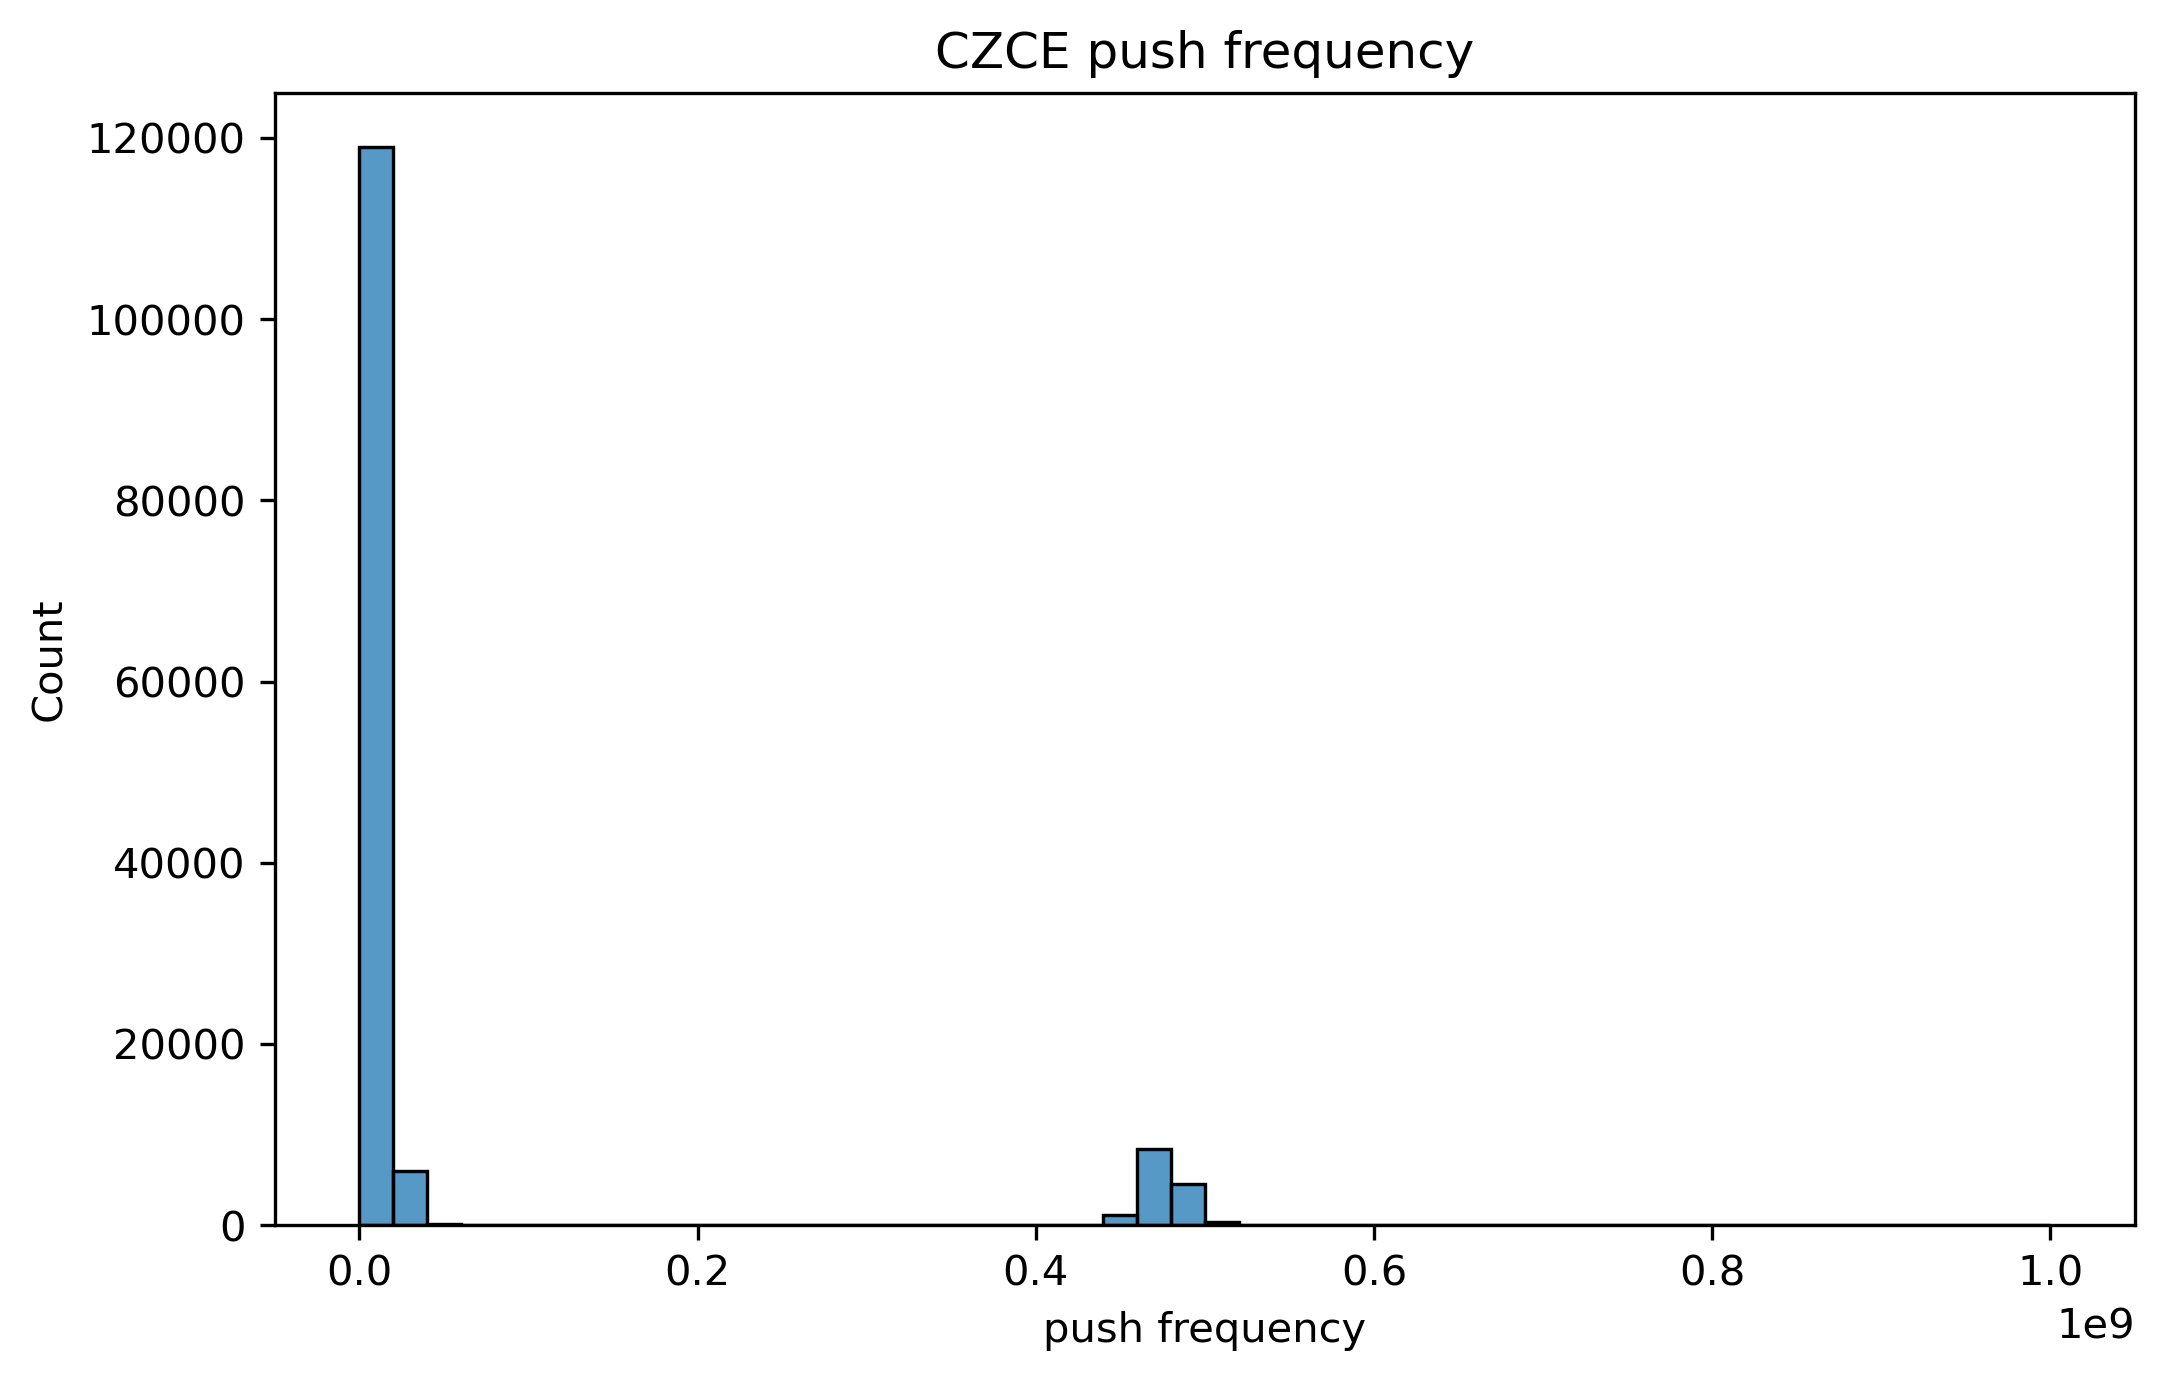

max: 1738432303412.0, min: 1139.0
Proportion of records with time_diff > 1000000000: 0.00458


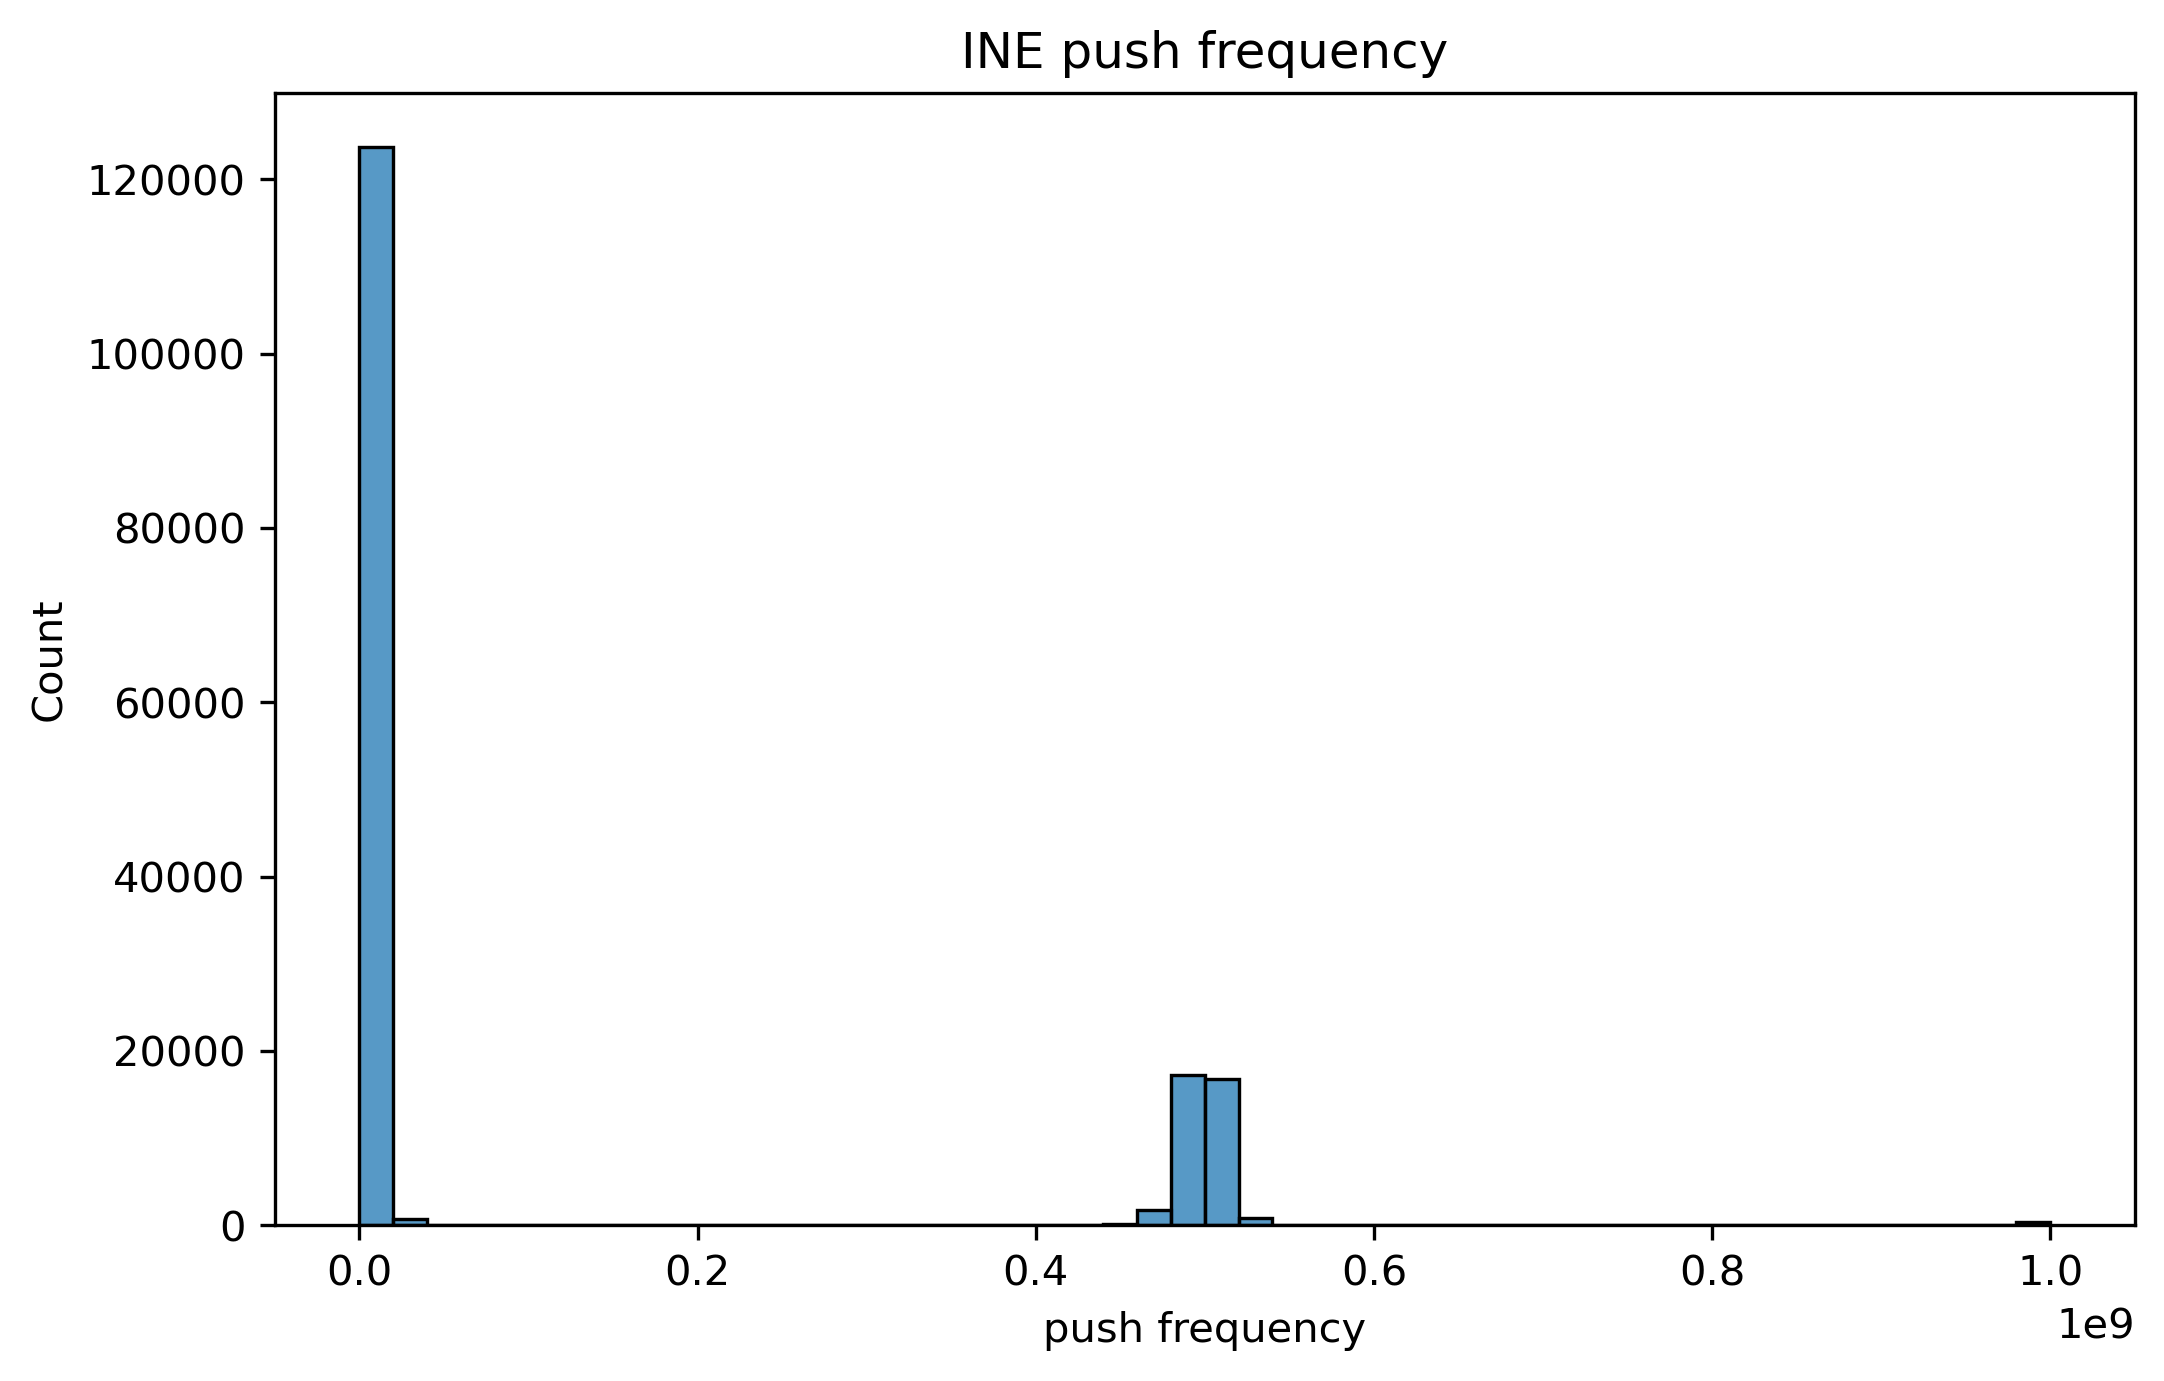

In [14]:
for ExchangeID in df["ExchangeID"].unique():
    
    time_diff = df[df["ExchangeID"]==ExchangeID]["LocalTime"].diff().values
    time_diff = time_diff[~np.isnan(time_diff)]
    print("max: {}, min: {}".format(np.max(time_diff), np.min(time_diff)))
    print("Proportion of records with time_diff > 1000000000: {:.5f}".format(np.sum(np.where((time_diff > 1000000000), 1, 0))/df[df["ExchangeID"]==ExchangeID].shape[0]))
    time_diff = np.delete(time_diff, np.where((time_diff >= 1000000000)))
    
    plt.figure(figsize=(8,5),dpi=300)
    sb.histplot(x=time_diff, bins=50)
    plt.xlabel("push frequency")

    plt.title("{} push frequency".format(ExchangeID))
    plt.savefig("project_images/push_freq_{}.png".format(ExchangeID))
    plt.show()
    


四个交易所的推送间隔分布在1微秒到半小时之间，从直方图可以很明显看出每个交易所的推送间隔都可以聚成两个组，分别是微秒级和百毫秒级，以微秒级为主。百毫秒级主要聚集在0.5秒左右。推测，每秒钟传两次，微秒级的间隔是将整包tick分成每个instrumentID的tick所用的时间。

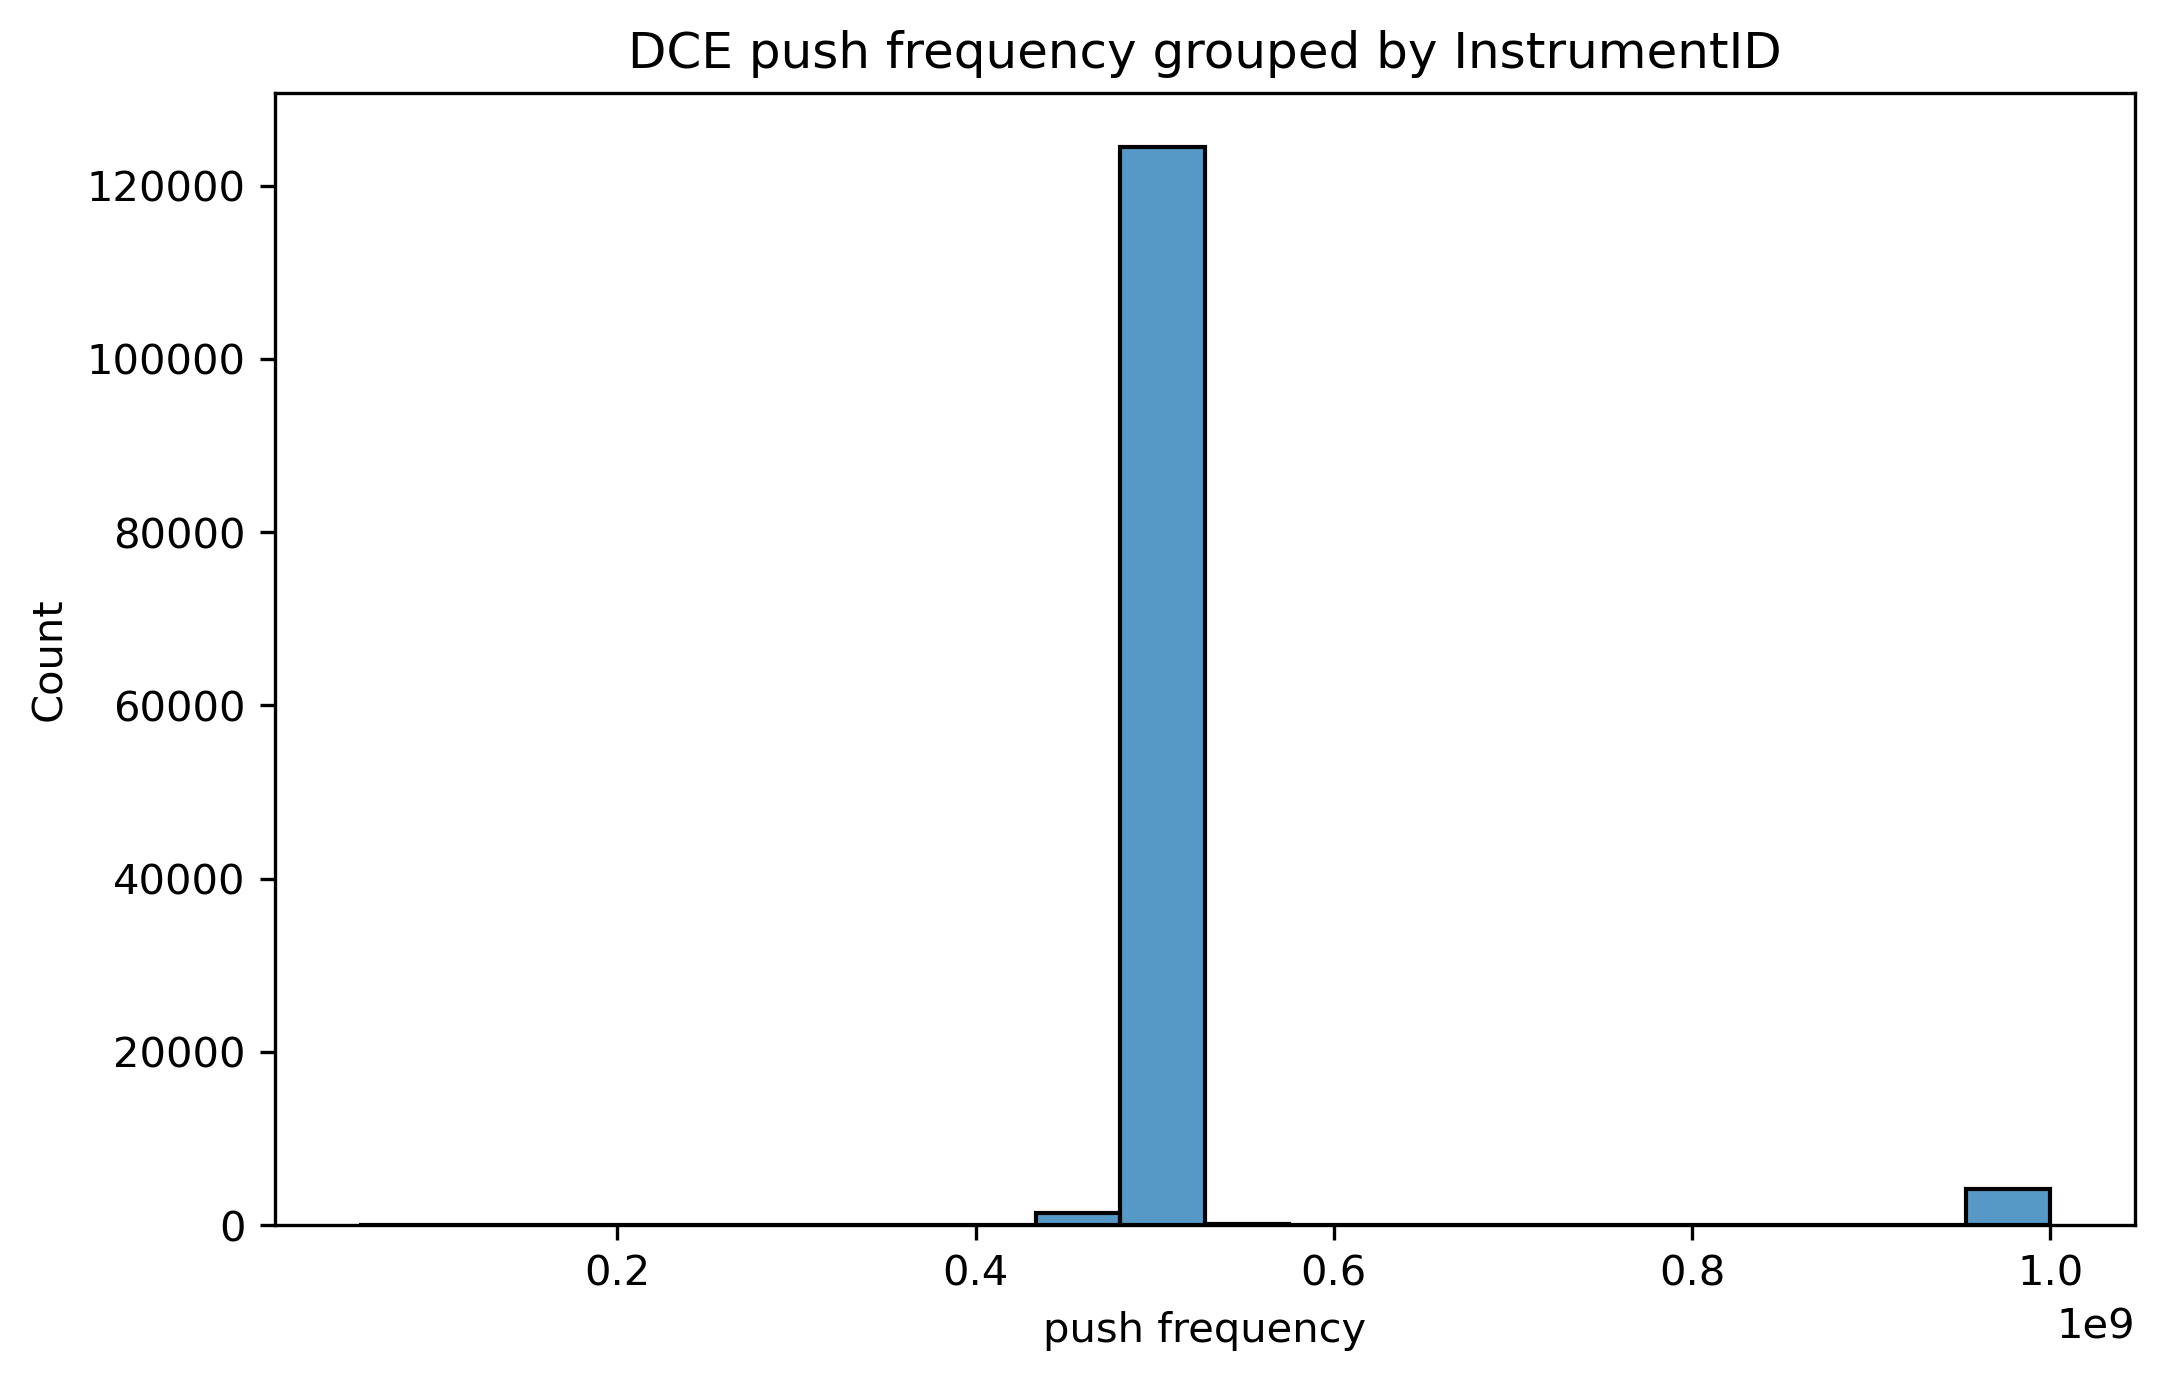

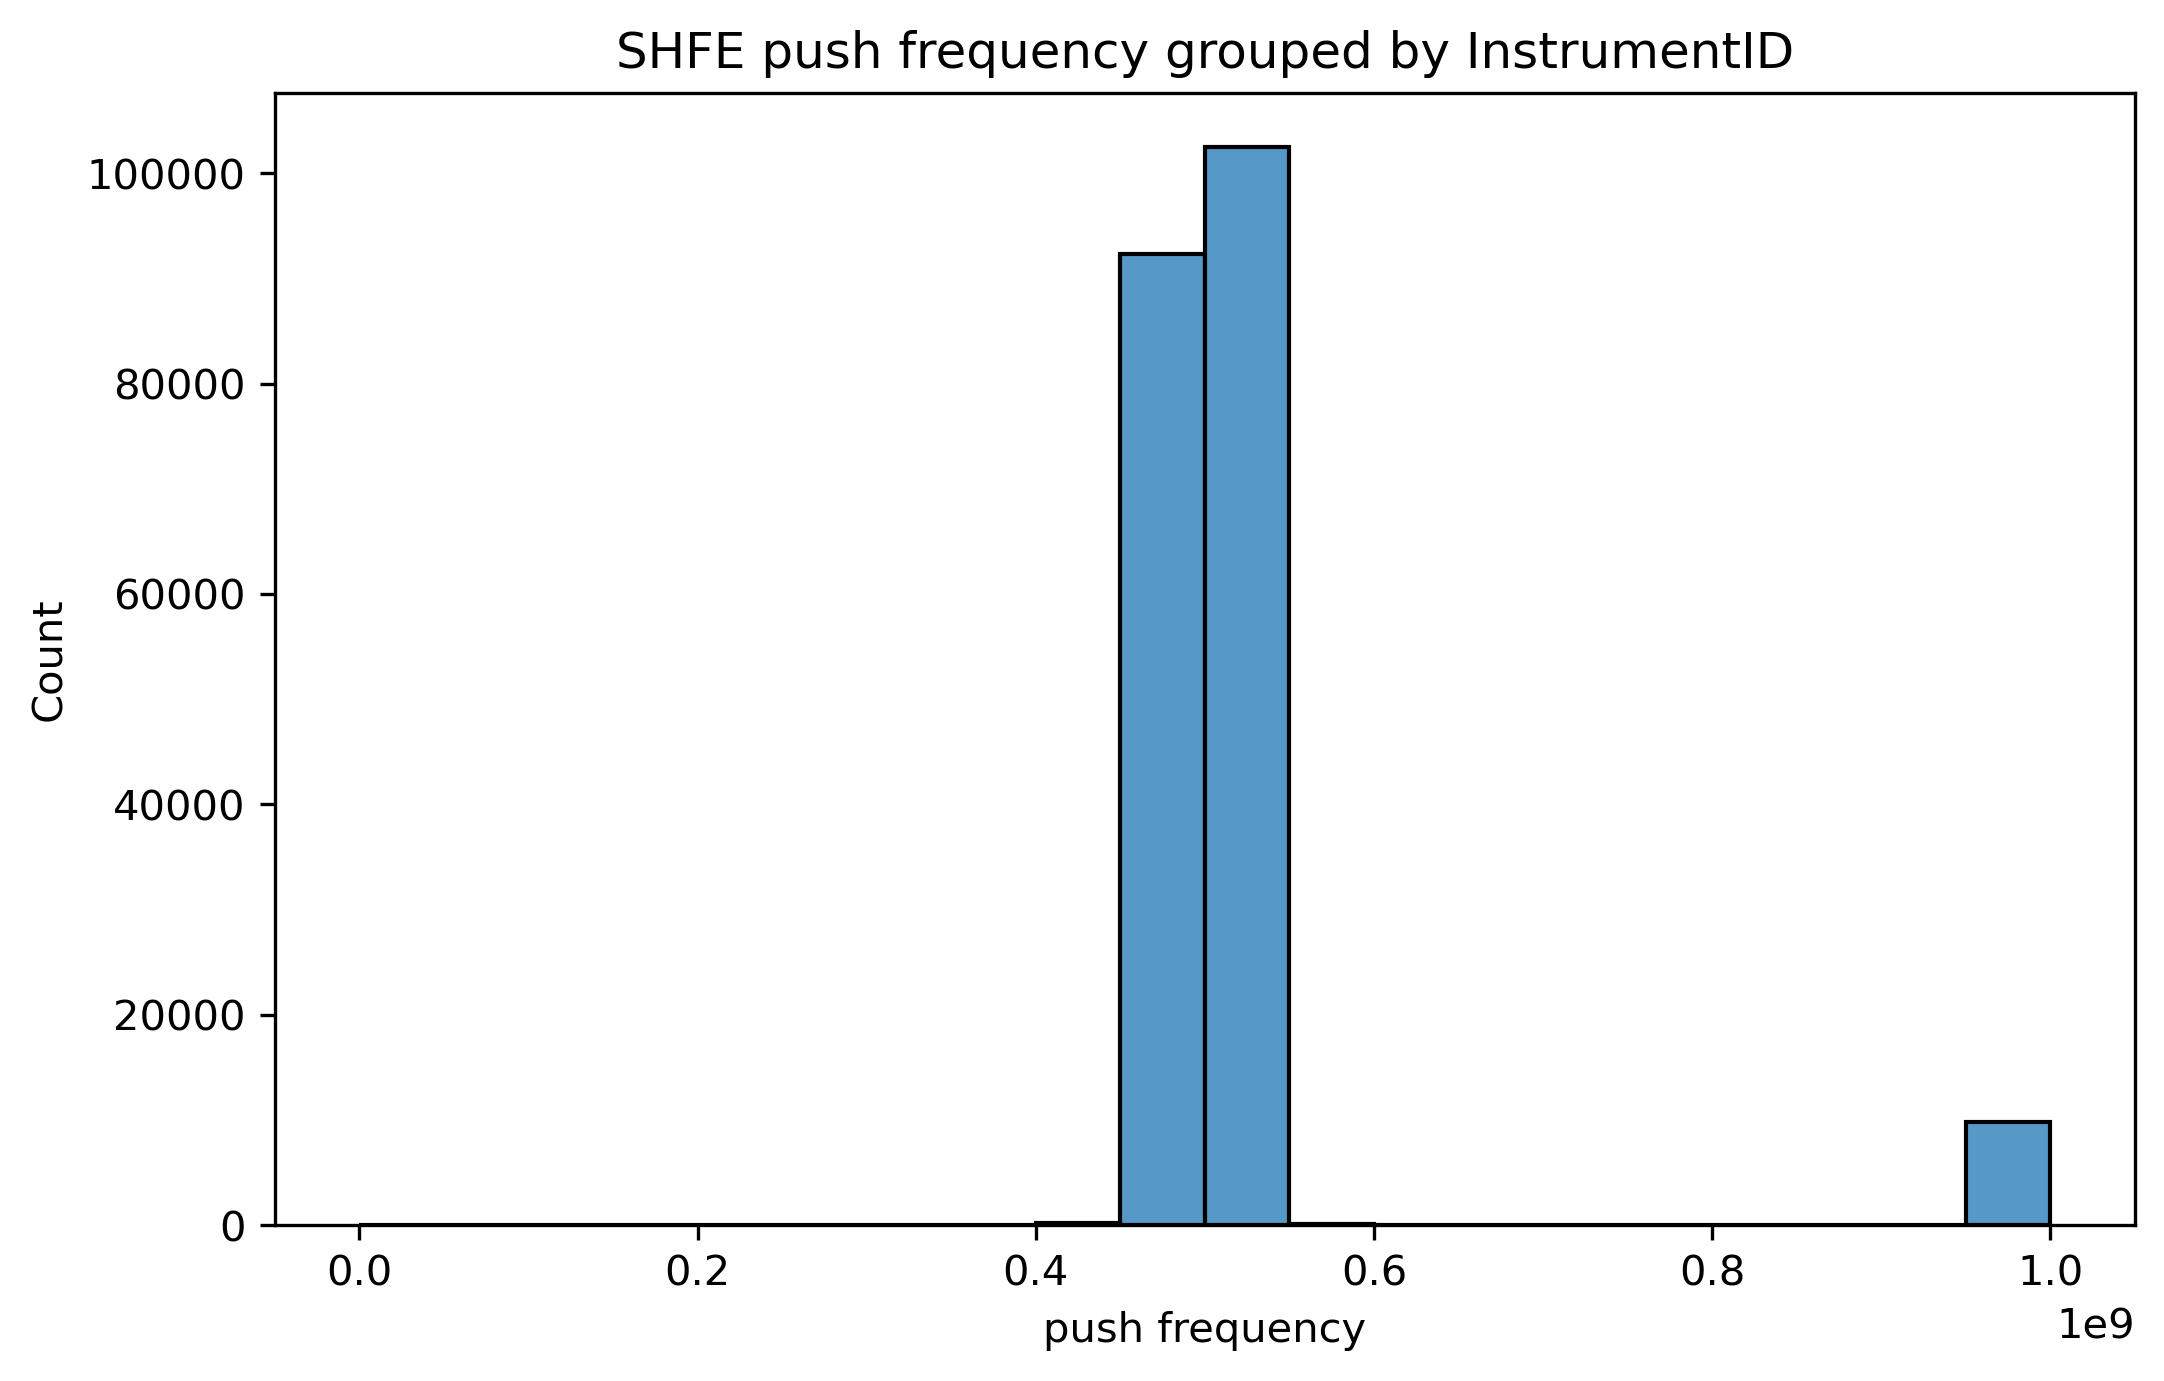

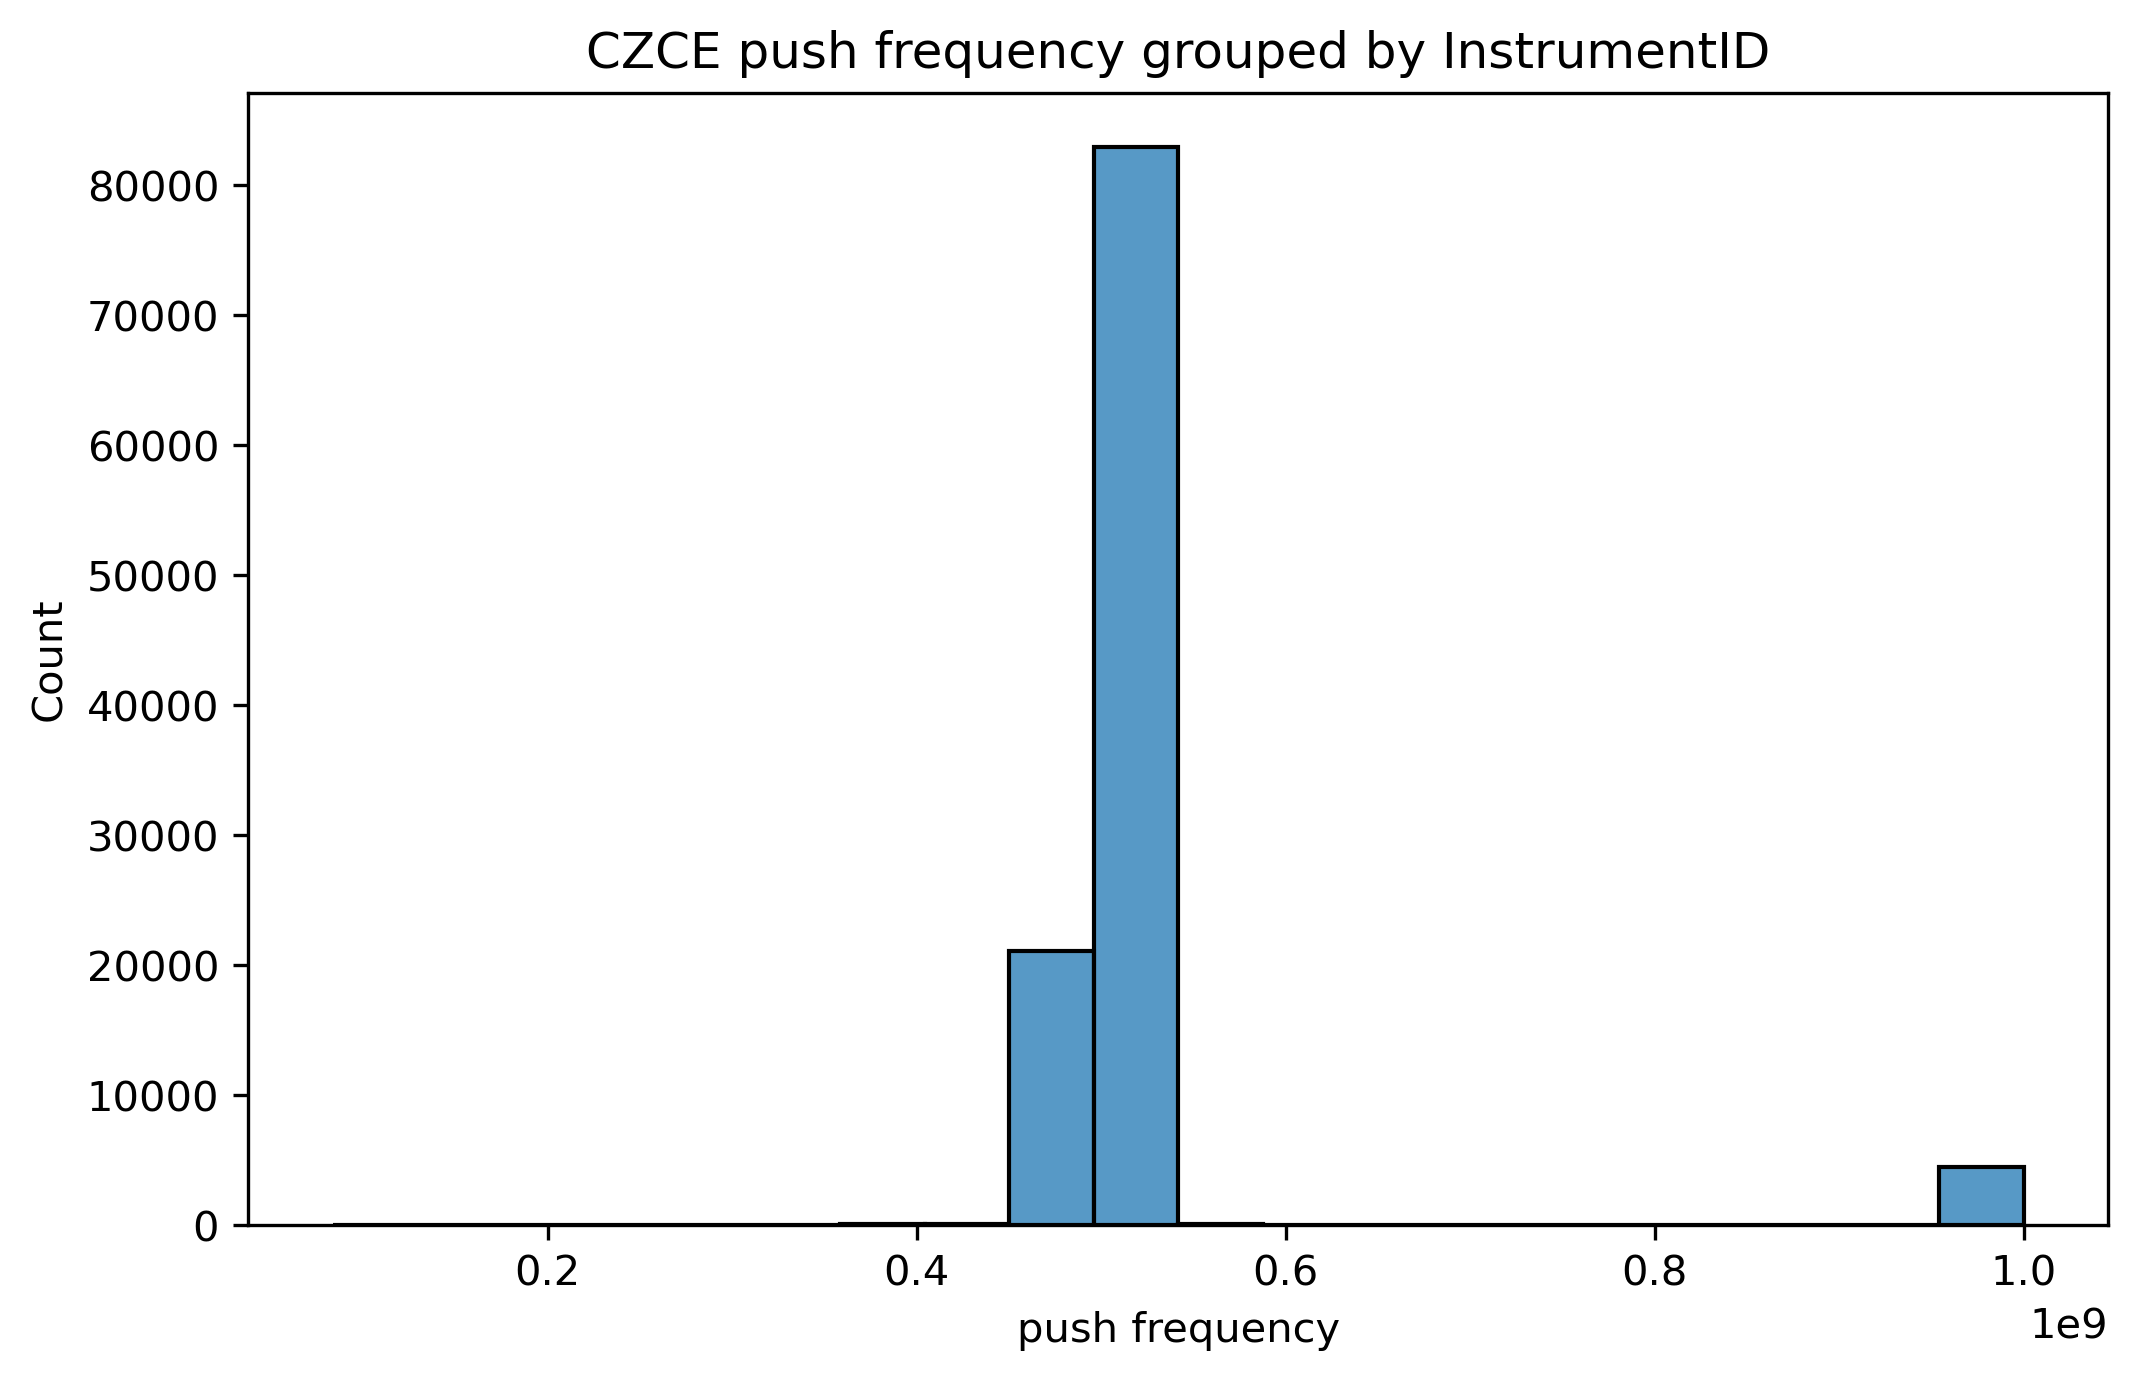

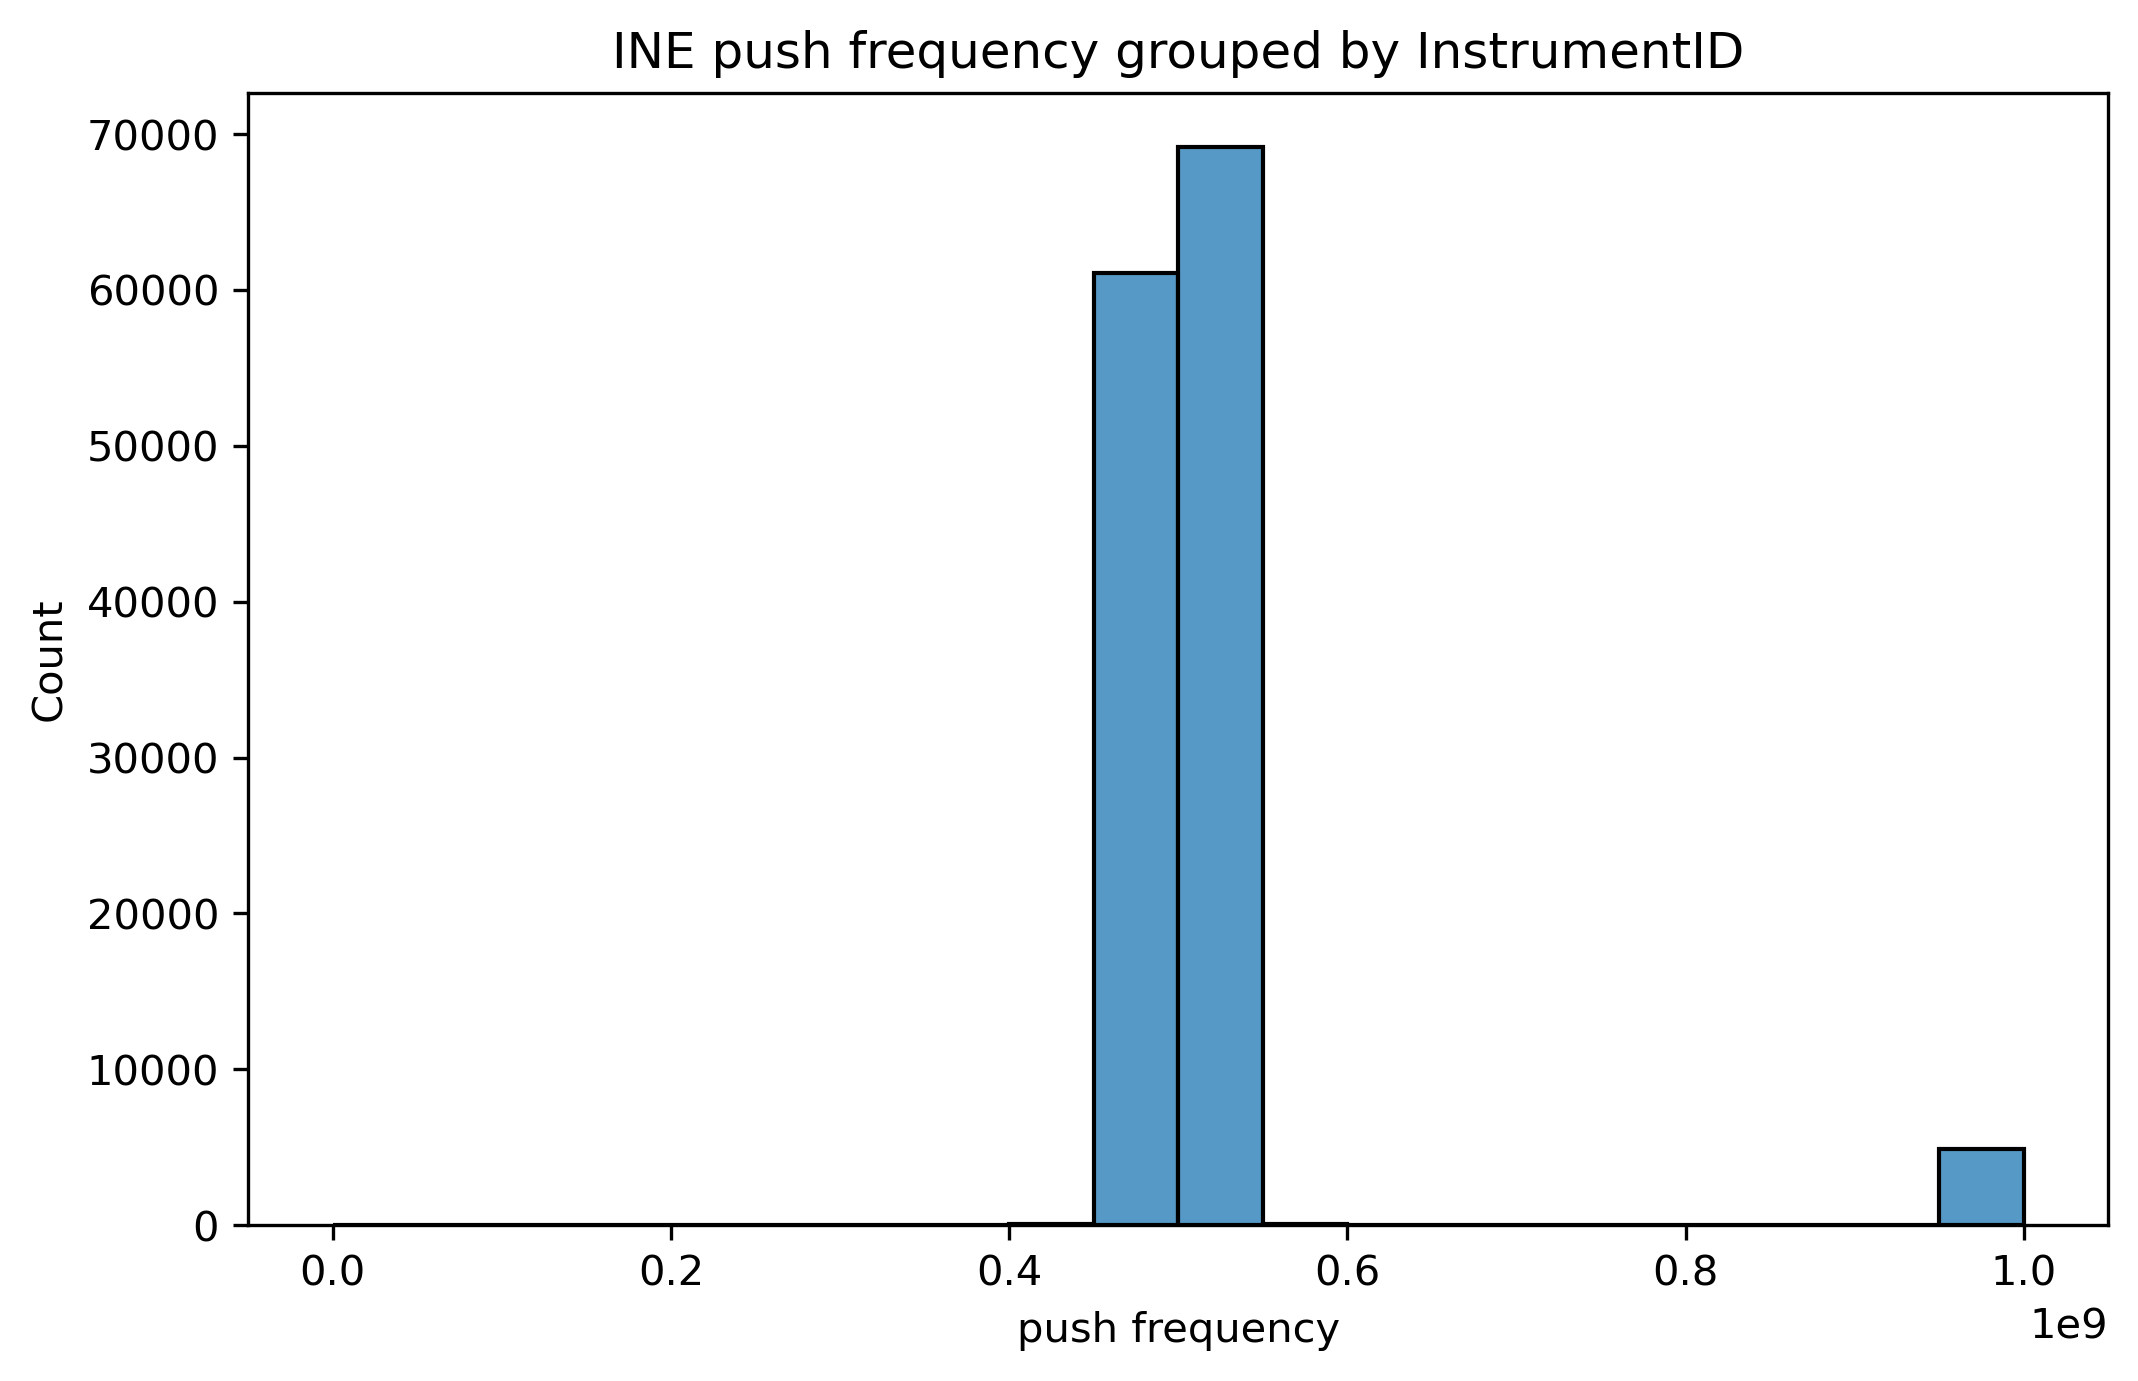

In [15]:
for ExchangeID in df["ExchangeID"].unique():
    
    time_diff = np.sort(df[df["ExchangeID"] == ExchangeID].groupby(["InstrumentID"])["LocalTime"].diff().dropna().values)
    time_diff = np.delete(time_diff, np.where(time_diff >= 1000000000))
    
    plt.figure(figsize=(8,5),dpi=300)
    sb.histplot(x=time_diff, bins=20)
    
    plt.xlabel("push frequency")
    plt.title("{} push frequency grouped by InstrumentID".format(ExchangeID))
    plt.savefig("project_images/push_freq_{}_grouped.png".format(ExchangeID))
    plt.show()


将LocalTime在根据交易所分组的基础上根据InstrumentID再分组，求得推送间隔后在根据交易所汇总。可以看到直方图中微秒级的推送间隔被去除掉了，这里可以说明微秒级的时间间隔是对同一批推送数据进行处理所消耗的时间。

In [16]:
df["UpdateMillisec"].value_counts()

0      348897
500    209385
444       737
443       725
941       724
        ...  
385         5
412         5
896         4
356         3
373         2
Name: UpdateMillisec, Length: 1000, dtype: int64

UpdateMillisec的分布集中在0和500，进一步说明推送应该是0.5秒一次。

### 探索ActionDay，TradingDay和实际交易时间的关系

In [17]:
df["LocalTime_datetime"] = pd.to_datetime(df["LocalTime"]).dt.tz_localize(tz="GMT").dt.tz_convert(tz="Asia/Shanghai")

将LocalTime转为datetime格式，以便和ActionDay，TradingDay进行比较

In [18]:
for ExchangeID in df["ExchangeID"].unique(): 
    print(ExchangeID)
    print()
    print("ActionDay distribution:")
    print(df[df["ExchangeID"]==ExchangeID]["ActionDay"].value_counts())
    print()
    print("TradingDay distribution:")
    print(df[df["ExchangeID"]==ExchangeID]["TradingDay"].value_counts())
    print()
    print("LocalTime hour distribution:")
    print(df[df["ExchangeID"]==ExchangeID]["LocalTime_datetime"].dt.strftime("%Y%m%d %H").value_counts())
    print()
    print("UpdateTime hour distribution:")
    print(pd.to_datetime(df[df["ExchangeID"]==ExchangeID]["UpdateTime"]).dt.hour.value_counts())
    print("-----------------------------------")

DCE

ActionDay distribution:
20211222    146635
Name: ActionDay, dtype: int64

TradingDay distribution:
20211222    146635
Name: TradingDay, dtype: int64

LocalTime hour distribution:
20211221 21    78799
20211221 22    67788
20211221 20       37
20211221 23       11
Name: LocalTime_datetime, dtype: int64

UpdateTime hour distribution:
21    78804
22    67789
18       20
20       17
23        5
Name: UpdateTime, dtype: int64
-----------------------------------
SHFE

ActionDay distribution:
20211221    176367
20211222     79531
Name: ActionDay, dtype: int64

TradingDay distribution:
20211222    255898
Name: TradingDay, dtype: int64

LocalTime hour distribution:
20211221 21    60107
20211221 23    59649
20211221 22    56562
20211222 00    37261
20211222 01    26262
20211222 02    16017
20211221 20       40
Name: LocalTime_datetime, dtype: int64

UpdateTime hour distribution:
21    60114
23    59651
22    56562
0     37258
1     26275
2     15998
18       20
20       20
Name: UpdateTime, 

从统计结果可以看出该份数据只有夜盘交易数据，DCE和CZCE的数据中没有实际发生在2021年12月22日的交易数据，而SHFE和INE则从20点到2点都有数据。

DCE当天夜盘的ActionDay和TradingDay都会被记在下一个交易日； SHFE和INE当天夜盘的24点前的数据ActionDay会被记为当天，24点后会被记为下一个交易日，也就是说ActionDay记录的是实际发生日。而TradingDay则会被记为下一个交易日； CZCE当天夜盘ActionDay和TradingDay都会被记为当天。

### EDA

In [19]:
df.isnull().sum()

LocalTime             0
TradingDay            0
InstrumentID          0
ExchangeID            0
LastPrice             0
Volume                0
Turnover              0
UpperLimitPrice       0
LowerLimitPrice       0
UpdateTime            0
UpdateMillisec        0
ActionDay             0
UpdateTime_full       0
LocalTime_datetime    0
dtype: int64

检查缺失值：无缺失值

In [20]:
print(np.sum(np.where((df["LastPrice"] <= 0), 1, 0)))
print(np.sum(np.where((df["UpperLimitPrice"] <= 0), 1, 0)))
print(np.sum(np.where((df["LowerLimitPrice"] <= 0), 1, 0)))


0
0
0


检查价格是否为负或0：价格全部为正

In [21]:
print(np.sum(np.where((df["LastPrice"] > df["UpperLimitPrice"]), 1, 0)))
print(np.sum(np.where((df["LastPrice"] < df["LowerLimitPrice"]), 1, 0)))


0
0


检查LastPrice是否超过涨停跌停板范围：无LastPrice超过涨跌停板范围。

In [22]:
df.groupby(["InstrumentID"])["ExchangeID"].nunique().nunique()

1

检查InstrumentID是否对应唯一的ExchangeID：InstrumentID有唯一对应ExchangeID（每个合约只在一个交易所交易）

In [23]:
df.groupby(["InstrumentID"])["Volume"].apply(lambda x: x.is_monotonic).unique()

array([ True])

检查Volume的单调性：Volume单调递增

In [24]:
print(np.sum(np.where((df["Volume"] <= 0), 1, 0)))
print(np.sum(np.where((df["Volume"] < 0), 1, 0)))

27118
0


检查volumn异常值：存在volumn=0的情况

In [25]:
df.groupby(["InstrumentID"])["Turnover"].apply(lambda x: x.is_monotonic).unique()

array([ True])

检查Turnover的单调性：Turnover单调递增

In [26]:
print(np.sum(np.where((df["Turnover"] <= 0), 1, 0)))
print(np.sum(np.where((df["Turnover"] < 0), 1, 0)))

27118
0


检查Turnover异常值：存在Turnover=0的情况，与Volume相符

### 分钟bar合成

In [27]:
class tick:
    
    def __init__(self, LocalTime=None, TradingDay=None, ExchangeID=None, InstrumentID=None, LastPrice=None,\
                 Volume=None, Turnover=None, UpperLimitPrice=None, LowerLimitPrice=None, UpdateTime=None,\
                 UpdateMillisec=None, ActionDay=None):
        
        self.LocalTime = LocalTime
        self.TradingDay = TradingDay
        self.ExchangeID = ExchangeID
        self.InstrumentID = InstrumentID
        self.LastPrice = LastPrice
        self.Volume = Volume
        self.Turnover = Turnover
        self.UpperLimitPrice = UpperLimitPrice
        self.LowerLimitPrice = LowerLimitPrice
        self.UpdateTime = UpdateTime
        self.UpdateMillisec = UpdateMillisec
        self.ActionDay = ActionDay

class minbar:
    
    def __init__(self):
        
        self.datetime = None
        self.high = None
        self.low = None
        self.open = None
        self.close = None
        
        self.ExchangeID = None
        self.InstrumentID = None
        

In [28]:
class candlestick:
    
    def __init__(self):
        
        self.bar = None
        self.new_min = False
        
    def update(self, tick):
        
        #初始化
        if not self.bar:
            
            self.bar = minbar()
            self.new_min = True
        
        #进入新一分钟
        elif tick.LocalTime.minute != self.bar.datetime.minute or tick.LocalTime.hour != self.bar.datetime.hour:
            
            #保存上一分钟bar
            self.store(self.bar)
            #创建新分钟bar
            self.bar = minbar()
            self.new_min = True
        
        #初始化新一分钟bar的参数
        if self.new_min:
            
            self.bar.datetime = tick.LocalTime.replace(second=0, microsecond=0, nanosecond=0)
            self.bar.high = tick.LastPrice
            self.bar.low = tick.LastPrice
            self.bar.open = tick.LastPrice
            self.bar.close = tick.LastPrice

            self.bar.ExchangeID = tick.ExchangeID
            self.bar.InstrumentID = tick.InstrumentID
            self.new_min = False
        
        #更新当前分钟bar参数
        else:
            
            self.bar.high = max(tick.LastPrice, self.bar.high)
            self.bar.low = min(tick.LastPrice, self.bar.low)
            self.bar.close = tick.LastPrice     
    
    #用于保存分钟bar
    def store(self, bar):
        
        datetime_list.append(bar.datetime)
        high_list.append(bar.high)
        low_list.append(bar.low)
        open_list.append(bar.open)
        close_list.append(bar.close)
        ExchangeID_list.append(bar.ExchangeID)
        InstrumentID_list.append(bar.InstrumentID)
        

In [29]:
df_test = pd.read_parquet("2022interview.parquet")

InstrumentID_dict = {}

datetime_list = []
high_list = []
low_list = []
open_list = []
close_list = []
ExchangeID_list = []
InstrumentID_list = []

for row in df_test.itertuples(index=True, name='Pandas'):
        
    Tick = tick()
    Tick.LocalTime = pd.to_datetime(row.LocalTime).tz_localize(tz="GMT").tz_convert(tz="Asia/Shanghai")
    Tick.LastPrice = row.LastPrice
    Tick.ExchangeID = row.ExchangeID
    Tick.InstrumentID = row.InstrumentID
    Tick.Volume = row.Volume
    
    #过滤掉volume等于0的tick
    if Tick.Volume > 0:
        
        if Tick.InstrumentID not in InstrumentID_dict:

            InstrumentID_dict[Tick.InstrumentID] = candlestick()

        InstrumentID_dict[Tick.InstrumentID].update(Tick)
        
df_minbar = pd.DataFrame(
    {
        "datetime": datetime_list,
        "ExchangeID": ExchangeID_list,
        "InstrumentID": InstrumentID_list,
        "open": open_list,
        "high": high_list,
        "low": low_list,
        "close": close_list  
    }
)

df_minbar.to_csv("minbar_result.csv", index = False)


### 绘制k线图展示

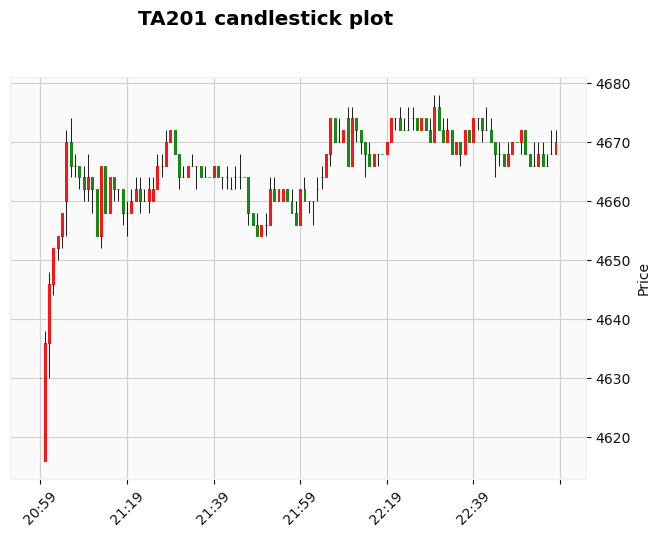

In [30]:
mc = mpl.make_marketcolors(up = "red", down = "green", edge = "inherit")
s = mpl.make_mpf_style(base_mpf_style = "yahoo", marketcolors = mc)

mpl.plot(
    df_minbar[df_minbar["InstrumentID"]=="TA201"].set_index("datetime").loc[:,"open":"close"],
    type="candle", 
    #mav =(3,6,9),
    title = "TA201 candlestick plot",  
    style = s,
    savefig = "project_images/candlestick_TA201"
    )

mpl.plot(
    df_minbar[df_minbar["InstrumentID"]=="TA201"].set_index("datetime").loc[:,"open":"close"],
    type="candle", 
    title = "TA201 candlestick plot",  
    style = s
    )

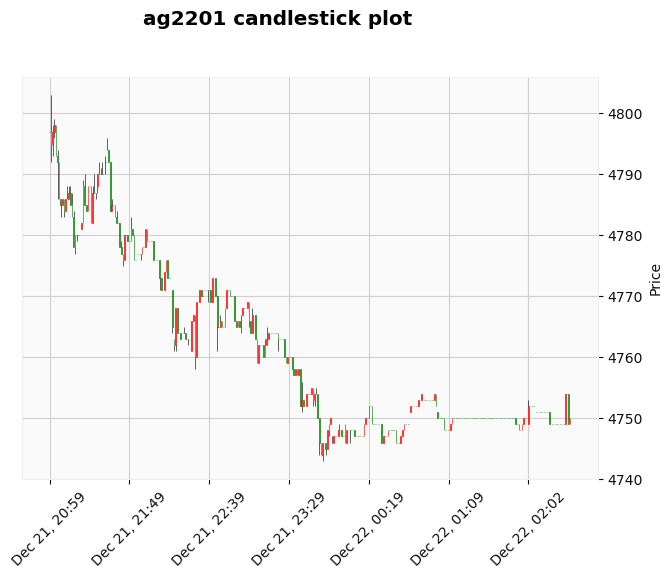

In [32]:
mpl.plot(
    df_minbar[df_minbar["InstrumentID"]=="ag2201"].set_index("datetime").loc[:,"open":"close"],
    type="candle", 
    title = "ag2201 candlestick plot",  
    style = s,
    savefig = "project_images/candlestick_ag2201"
    )

mpl.plot(
    df_minbar[df_minbar["InstrumentID"]=="ag2201"].set_index("datetime").loc[:,"open":"close"],
    type="candle", 
    title = "ag2201 candlestick plot",  
    style = s
    )

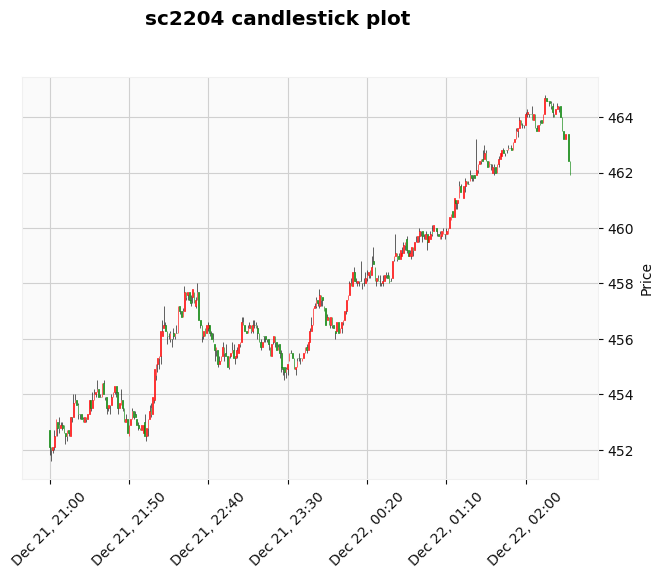

In [33]:
mpl.plot(
    df_minbar[df_minbar["InstrumentID"]=="sc2204"].set_index("datetime").loc[:,"open":"close"],
    type="candle", 
    title = "sc2204 candlestick plot",  
    style = s,
    savefig = "project_images/candlestick_sc2204"
    )

mpl.plot(
    df_minbar[df_minbar["InstrumentID"]=="sc2204"].set_index("datetime").loc[:,"open":"close"],
    type="candle", 
    title = "sc2204 candlestick plot",  
    style = s
    )